In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import scipy.stats
from scipy import signal

from clam import bouts
from clam.utils import peakdet
from clam.utils import filter_peaks_by_spacing

%matplotlib inline

In [2]:
def tail_beat_count(bout_start, bout_end, peak_locs, trough_locs):
    
    nbeats = []
    for i in range(len(bout_start)):
        
        startloc_r = np.argwhere(peak_locs > boutstart[i])[0]
        endloc_r = np.argwhere(peak_locs > boutend[i])[0]
        
        startloc_l = np.argwhere(trough_locs > boutstart[i])[0]
        endloc_l = np.argwhere(trough_locs > boutend[i])[0]        
        
        count_r = endloc_r - startloc_r
        count_l = endloc_l - startloc_l
        
        nbeats.append( (count_r[0] + count_l[0]) / 2 )
        
    
    return nbeats

In [15]:
load = np.load('trackdata.npz')

endPoints = load['endPoints']

framerate = 300


savedata = True
saveas = 'boutkinematics.npz'

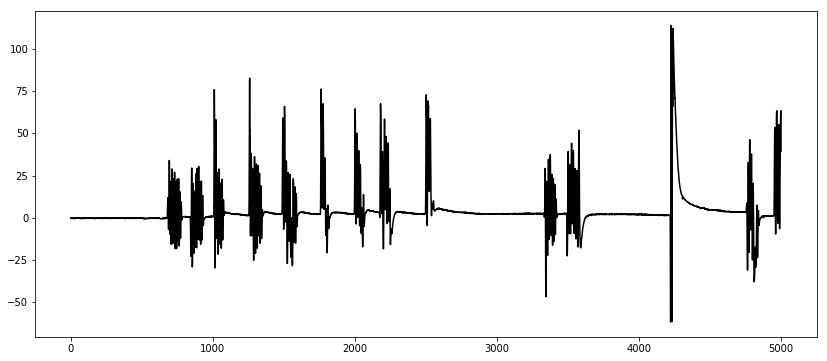

In [4]:
endRest = [np.median(endPoints[0]), np.median(endPoints[1])]

distances = []
d = 0
for i in range(len(endPoints[0])-1):
    d +=  (endPoints[0][i+1] - endPoints[0][i+1]) + (endPoints[1][i+1] - endPoints[1][i])

    distances.append(d)
    
plt.figure(figsize=[14,6])

plt.plot(distances, color='black')

rectified = [abs(x) for x in distances]

In [5]:
minspacing = 20 #milliseconds
framespacing = int(minspacing*framerate/1000)

#TODO load actual timestamp
timaxis = np.arange(0,len(distances)*1/framerate,1/framerate)

peaks,troughs = peakdet(distances, 10)

filtered_peaks = filter_peaks_by_spacing(peaks,framespacing)
filtered_troughs = filter_peaks_by_spacing(troughs,framespacing)

#plt.figure(figsize=[14,6])
#plt.plot(distances,color='black')
#plt.scatter(filtered_peaks[:,0],filtered_peaks[:,1],s=50,color='red')
#plt.scatter(filtered_troughs[:,0],filtered_troughs[:,1],s=50,color='blue')

locs = np.zeros(len(distances))
locs[filtered_peaks[:,0].astype(int)] = 1

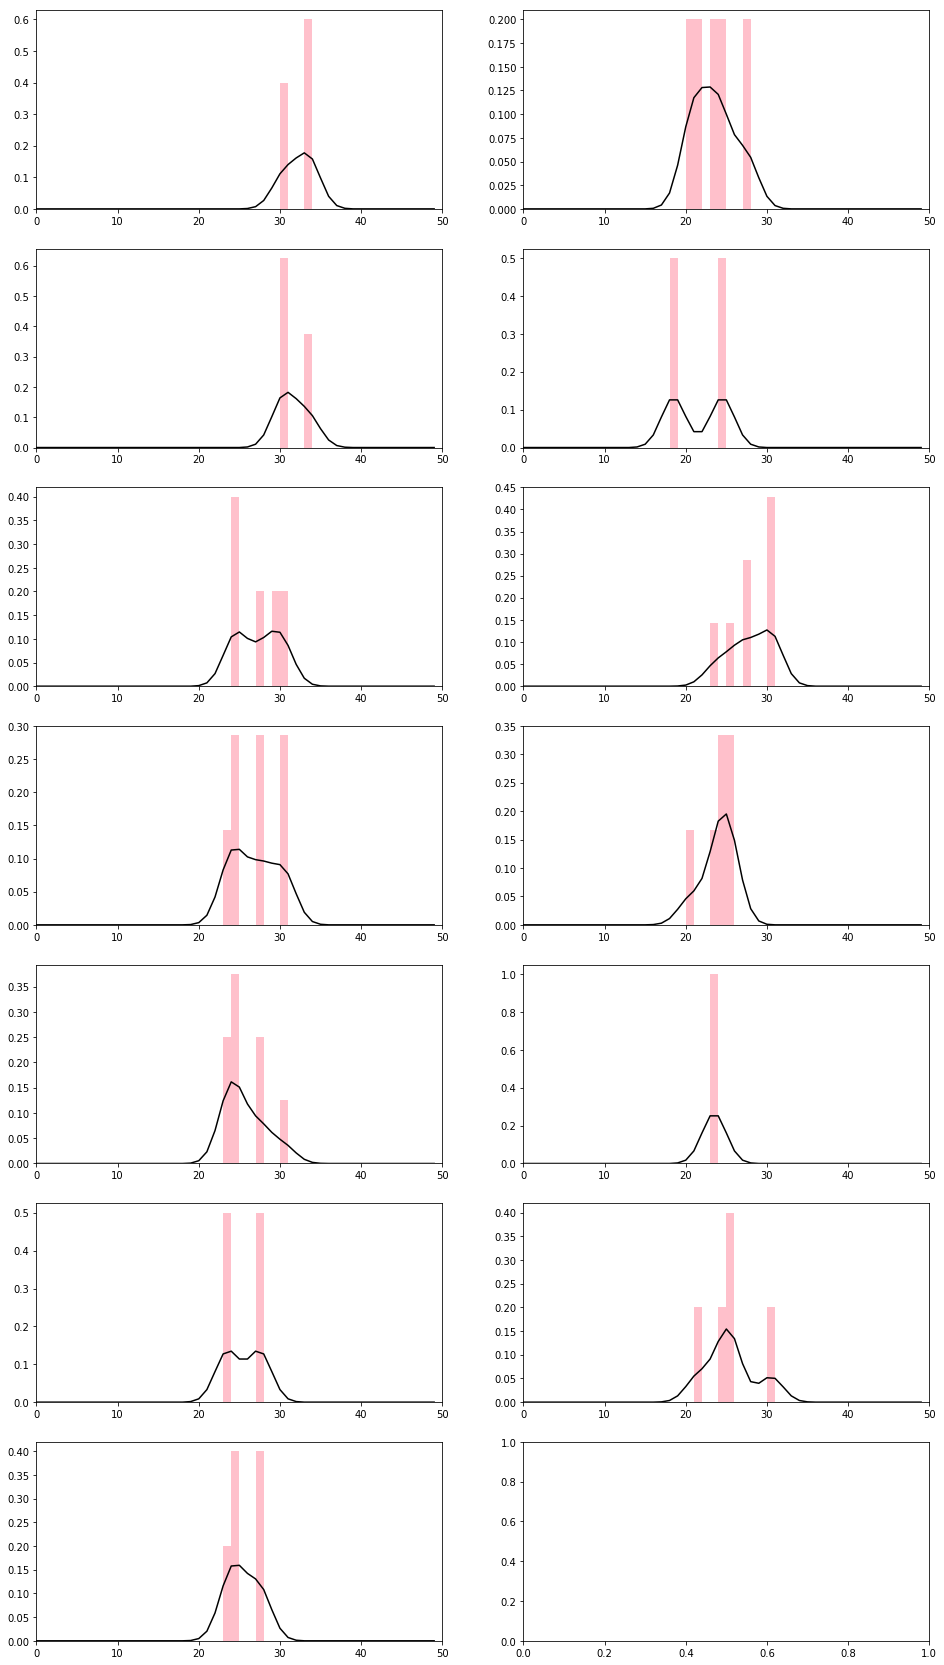

In [6]:
boutstart,boutend = bouts.bout_detect(rectified,5,20,7)

beat_count = tail_beat_count(boutstart, boutend, filtered_peaks[:,0], filtered_troughs[:,0])

duration = bouts.bout_duration([boutstart,boutend], timaxis)

tbf = [x/y for x,y in zip(beat_count,duration)]

peaktimes = [timaxis[int(x)] for x in filtered_peaks[:,0]]
peakdiffs = list(abs(np.diff(peaktimes)))
peakdiffs.append(0)


itbf = [0]*len(timaxis)

for (index,replacement) in zip(filtered_peaks[:,0], peakdiffs):
    itbf[int(index)] = replacement
    
for i in range(len(boutstart)):
    endloc = int(filtered_peaks[:,0][np.where(np.array(filtered_peaks[:,0]) < boutend[i])[0][-1]])
    itbf[endloc] = 0

for i in range(len(itbf)):
    if itbf[i] > 0:
        itbf[i] = 1/itbf[i]
        
        
nbouts = len(boutstart)
max_freq = 50
sigma = 1.5
kernel_bins = 1
kernel_edges = np.arange(-3*sigma,3*sigma+1,kernel_bins)
kernel = scipy.stats.norm.pdf(kernel_edges,loc=0,scale=sigma)*kernel_bins


columns = 2
plotlim = (0,max_freq)
fig, axarr = plt.subplots(math.ceil(nbouts/columns),columns, figsize=[16,30])

bout_freqs = []
binned_freqs = []
cont_freqs = []

for i in range(len(boutstart)):
    
    freqs = itbf[boutstart[i]:boutend[i]]
    freqs = [x for x in freqs if x >0]
    bout_freqs.append(freqs)
    
    hist = axarr[i%math.ceil(nbouts/columns),
                 math.floor(i/(nbouts/columns))].hist(freqs,
                 range = [0,50], bins = 50, color = 'pink', normed=True)
    
    binned_freqs.append(list(hist[0]))
    s = scipy.signal.convolve(hist[0],kernel,'same')
    cont_freqs.append(s)

    axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].plot(s, color='black')
    
    axarr[i%math.ceil(nbouts/columns),math.floor(i/(nbouts/columns))].set_xlim(0,max_freq)
    

In [14]:
idtc_sigma = 1.5

idtc_kernel = np.arange(-3*sigma,3*sigma,kernel_bins)
idtc_kernel = scipy.stats.norm.pdf(idtc_kernel, loc = 0 ,scale = idtc_sigma)

tuning_range = np.arange(0,max_freq,1)


f = 25

idtc = np.zeros(len(tuning_range))    
idtc[f] = 1
idtc = scipy.signal.convolve(idtc,idtc_kernel,'same')

for i in range(len(cont_freqs)):

    t = idtc*cont_freqs[i]/max(cont_freqs[i])      

In [16]:
if savedata:
    np.savez(saveas, bout_frequency_composition = cont_freqs)